# Main anaysis

### Setup

#### Imports

In [568]:
import hydra

import numpy as np
import pandas as pd
import plotnine as pn

from hydra.core.global_hydra import GlobalHydra

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game
from misc.util import save_plot

#### Overrides

In [569]:
overrides = [
    "game.universe=100",
    "game.num_signals=100",
    "game.meaning_dist_pi=0.5",
    "simulation/dynamics=imprecise_conditional_imitation",
    "simulation.dynamics.imprecise_imitation_alpha=0.5",
    "simulation.dynamics.max_its=1e5", # important to specify maxits
] # n.b.: do not include multirun overrides, we will filter from columns in the dataframe.

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)


#### Helper function to filter data by config data

In [570]:
def get_df_subsetted_by_meaning_dists(df: pd.DataFrame, config) -> pd.DataFrame:
    """Return a subset of the data consistent with the specifications in the curve_metadata config."""
    curve_metadata = config.game

    # See src/get_all_data.py
    universe = df["universe"].astype(str) == str(curve_metadata.universe)
    prior = df["prior"].astype(str) == str(curve_metadata.prior)
    num_signals = df["num_signals"] == curve_metadata.num_signals # this is prob not necessary
    distance = df["distance"] == curve_metadata.distance

    meaning_dist_pi = df["meaning_dist_pi"] == curve_metadata.meaning_dist_pi

    imprecise_imitation_alpha = df["imprecise_imitation_alpha"].isin([curve_metadata.meaning_dist_pi, np.nan]) # allows curve, and constraints to be the same as curve.

    max_its = df["max_its"].isin([config.simulation.dynamics.max_its, np.nan]) # allows curve

    # temporary filtering
    not_binary = df["discriminative_need_gamma"] != 1e100

    df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_pi & imprecise_imitation_alpha & max_its & not_binary]

    return df_subsetted

#### Load data

In [571]:
all_data_fp = "../../analysis_data/all_data.csv"
df_all = pd.read_csv(all_data_fp)
df_all

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_69316/1129496392.py:2: DtypeWarning: Columns (2,26) have mixed types. Specify dtype option on import or set low_memory=False.


,run_num,iteration,is_final_iteration,complexity,accuracy,distortion,mse,eu_gamma,kl_eb,min_epsilon,...,eu_gamma=0.21544346900318778,eu_gamma=0.5994842503189396,eu_gamma=2.1544346900318776,eu_gamma=1.6681005372000557,eu_gamma=1.2915496650148826,eu_gamma=3.5938136638046254,eu_gamma=4.641588833612772,eu_gamma=10.0,eu_gamma=5.994842503189396,eu_gamma=7.742636826811246
0,0.0,3814.0,True,0.000002,0.000002,3.199885,1654.755533,1.0,0.000843,1.334765e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1.0,False,0.280089,0.071142,3.236585,1661.585846,1.0,0.356071,2.086528e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,2.0,False,0.049313,0.039869,3.224959,1661.251930,1.0,0.089149,9.413529e-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,3.0,False,0.034326,0.030577,3.220059,1661.028972,1.0,0.063656,3.729323e-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,4.0,False,0.027823,0.025686,3.217185,1660.852701,1.0,0.051746,2.121939e-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280251,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,0.664532,0.471084,0.279723,0.308425,0.343242,0.24503,0.238039,0.23428,0.235239,0.234433
280252,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,0.664532,0.471084,0.279723,0.308425,0.343242,0.24503,0.238039,0.23428,0.235239,0.234433
280253,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,0.664532,0.471084,0.279723,0.308425,0.343242,0.24503,0.238039,0.23428,0.235239,0.234433
280254,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,0.664532,0.471084,0.279723,0.308425,0.343242,0.24503,0.238039,0.23428,0.235239,0.234433


#### Filter

In [572]:
df = get_df_subsetted_by_meaning_dists(df_all, config)
df

,run_num,iteration,is_final_iteration,complexity,accuracy,distortion,mse,eu_gamma,kl_eb,min_epsilon,...,eu_gamma=0.21544346900318778,eu_gamma=0.5994842503189396,eu_gamma=2.1544346900318776,eu_gamma=1.6681005372000557,eu_gamma=1.2915496650148826,eu_gamma=3.5938136638046254,eu_gamma=4.641588833612772,eu_gamma=10.0,eu_gamma=5.994842503189396,eu_gamma=7.742636826811246
0,0.0,3814.0,True,0.000002,0.000002,3.199885,1654.755533,1.0,0.000843,1.334765e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1.0,False,0.280089,0.071142,3.236585,1661.585846,1.0,0.356071,2.086528e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,2.0,False,0.049313,0.039869,3.224959,1661.251930,1.0,0.089149,9.413529e-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,3.0,False,0.034326,0.030577,3.220059,1661.028972,1.0,0.063656,3.729323e-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,4.0,False,0.027823,0.025686,3.217185,1660.852701,1.0,0.051746,2.121939e-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280251,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,0.664532,0.471084,0.279723,0.308425,0.343242,0.24503,0.238039,0.23428,0.235239,0.234433
280252,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,0.664532,0.471084,0.279723,0.308425,0.343242,0.24503,0.238039,0.23428,0.235239,0.234433
280253,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,0.664532,0.471084,0.279723,0.308425,0.343242,0.24503,0.238039,0.23428,0.235239,0.234433
280254,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,0.664532,0.471084,0.279723,0.308425,0.343242,0.24503,0.238039,0.23428,0.235239,0.234433


In [573]:
df[df["meaning_dist_pi"] == 0.5].discriminative_need_gamma.value_counts()

discriminative_need_gamma
7.742637e-07    3208
7.742637e-04    3086
1.668101e-03    3074
1.668101e+00    3072
2.154435e+00    3072
                ... 
7.742637e-09    2452
1.668101e-08    2452
1.291550e-09    2452
2.782559e-09    2452
2.154435e-10    2452
Name: count, Length: 100, dtype: int64

Make sure seed is a discrete variable

In [574]:
df["seed"] = df["seed"].astype(str)

Separate out observations into curves and simulation points

In [575]:
df_final_points = df[df["point_type"] == "simulation"]
df_ib_bound = df[df["point_type"] == "ib_bound"]
df_mse_bound = df[df["point_type"] == "mse_bound"]

Restrict dynamics

In [576]:
df_final_points = df_final_points[df_final_points["dynamics"] == "imprecise_conditional_imitation"]

How does discriminative_need_gamma range?

In [577]:
df_final_points.discriminative_need_gamma.unique()

array([2.15443469e-10, 3.59381366e-10, 2.78255940e-10, 1.66810054e-10,
       1.00000000e-10, 1.29154967e-10, 1.00000000e-09, 7.74263683e-10,
       1.66810054e-09, 4.64158883e-10, 5.99484250e-10, 1.00000000e-08,
       1.29154967e-08, 2.15443469e-09, 4.64158883e-09, 5.99484250e-09,
       3.59381366e-09, 2.78255940e-09, 1.00000000e-06, 1.29154967e-09,
       1.66810054e-08, 1.00000000e-07, 1.29154967e-07, 7.74263683e-09,
       1.29154967e-06, 3.59381366e-08, 1.66810054e-07, 3.59381366e-07,
       2.15443469e-08, 7.74263683e-08, 2.78255940e-08, 4.64158883e-07,
       5.99484250e-08, 2.15443469e-07, 4.64158883e-08, 7.74263683e-07,
       5.99484250e-07, 2.78255940e-07, 1.66810054e-06, 3.59381366e-06,
       2.15443469e-06, 2.78255940e-06, 4.64158883e-06, 1.66810054e-05,
       1.00000000e-05, 5.99484250e-06, 1.29154967e-05, 1.00000000e-02,
       1.29154967e-04, 2.15443469e-05, 1.29154967e-03, 1.00000000e-03,
       5.99484250e-05, 7.74263683e-06, 3.59381366e-04, 4.64158883e-04,
      

In [578]:
# How does seed range?
df_final_points.seed.unique()

array(['7.0', '3.0', '0.0', '1.0', '2.0', '4.0', '5.0', '6.0'],
      dtype=object)

In [579]:
# Remember, popuation_init_gamma is nan if we go with the simple uniform sampling init
df_final_points.population_init_tau.unique()

array([nan])

### Visualize

In [580]:
# Make sure complexity max is np.log2(100)
assert np.allclose(df_ib_bound.complexity.max(), np.log2(100))

#### First visualize all data, across initializations and seeds

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 82 rows containing missing values.


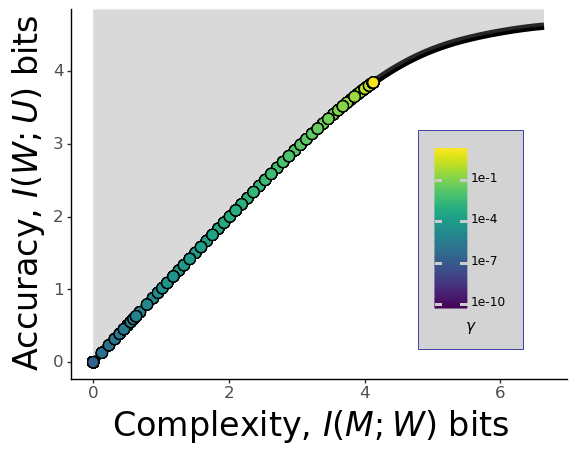

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 82 rows containing missing values.



Saved a plot to figures/systems_on_bound.png


In [609]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_ib_bound, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=3) # IB curve
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=np.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            fill="discriminative_need_gamma",
            # fill="imprecise_imitation_gamma",
            # shape="seed",
            ),
        # alpha=0.3,
        size=4,
    )
    + pn.labs(fill="$\\gamma$")
    + pn.scale_fill_continuous(
        trans = "log10",
    )
    + pn.xlim([0,np.log2(100)])
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        legend_position=(0.75, 0.4),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            ),
    )     

)
print(plot)
save_plot(
    "figures/systems_on_bound.png",
    plot,
)

In [628]:
# Converged results look a bit unevenly spread, dow many points do we have?
df_final_points.discriminative_need_gamma.value_counts()

discriminative_need_gamma
2.154435e-10    8
2.154435e-04    8
1.668101e-04    8
7.742637e-04    8
2.782559e-04    8
               ..
2.782559e-08    8
7.742637e-08    8
2.154435e-08    8
3.593814e-07    8
7.742637e+00    8
Name: count, Length: 100, dtype: int64

In [582]:
# Double check no min_epsilons are negative
df_final_points[df_final_points.min_epsilon < 0]

,run_num,iteration,is_final_iteration,complexity,accuracy,distortion,mse,eu_gamma,kl_eb,min_epsilon,...,eu_gamma=0.21544346900318778,eu_gamma=0.5994842503189396,eu_gamma=2.1544346900318776,eu_gamma=1.6681005372000557,eu_gamma=1.2915496650148826,eu_gamma=3.5938136638046254,eu_gamma=4.641588833612772,eu_gamma=10.0,eu_gamma=5.994842503189396,eu_gamma=7.742636826811246
106282,0.0,26676.0,True,0.554068,0.553330,3.979811,676.837897,0.996873,0.003653,-2.571220e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106645,0.0,16968.0,True,0.554068,0.553330,4.101618,676.837897,0.996873,0.003653,-2.604425e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106994,0.0,19680.0,True,0.554068,0.553330,4.026274,676.837898,0.996873,0.003653,-2.597146e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107347,0.0,22091.0,True,0.554068,0.553330,3.861036,676.837898,0.996873,0.003653,-2.606386e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107704,0.0,19190.0,True,0.554068,0.553330,4.109107,676.837898,0.996873,0.003653,-2.610257e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108057,0.0,15983.0,True,0.554068,0.553330,3.934781,676.837897,0.996873,0.003653,-2.559902e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108404,0.0,24614.0,True,0.554068,0.553330,3.918105,676.837897,0.996873,0.003653,-2.555211e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108763,0.0,19433.0,True,0.554068,0.553330,3.903451,676.837896,0.996873,0.003653,-2.459671e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114800,0.0,19885.0,True,0.595556,0.594730,4.022194,623.512265,0.996282,0.005064,-4.234070e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115153,0.0,21074.0,True,0.595556,0.594730,3.861904,623.512266,0.996282,0.005064,-4.234154e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Distribution of efficiency loss across converged emergent systems

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_density : Removed 24 rows containing non-finite values.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/stats/stat_density.py:218: RuntimeWarning: invalid value encountered in divide
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/stats/stat_density.py:218: RuntimeWarning: invalid value encountered in divide
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/stats/stat_density.py:218: RuntimeWarning: invalid value encountered in divide
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/stats/stat_density.py:218: RuntimeWarning: invalid value encountered in divide
/Users/nathanielimel/miniforge3/envs/ibs

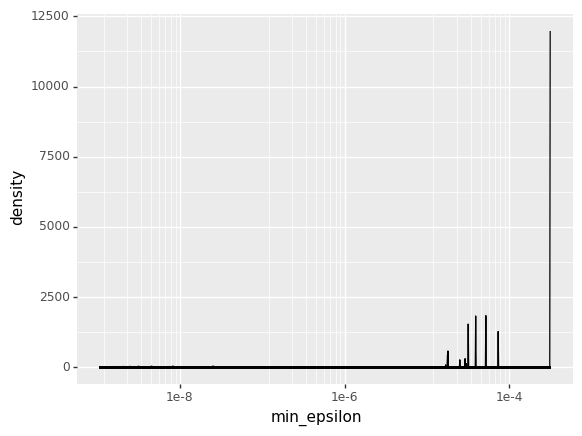

<ggplot: (891695162)>

In [583]:
df_final_points_gamma_discrete = df_final_points.copy()
df_final_points_gamma_discrete["discriminative_need_gamma"] = df_final_points_gamma_discrete["discriminative_need_gamma"].astype(str)

(
    pn.ggplot(
        df_final_points_gamma_discrete,
        pn.aes(
            x="min_epsilon",
            # fill="seed",
            fill="discriminative_need_gamma",
        )
    )
    # + pn.scale_fill_manual(values = fill_values_dict)
    + pn.geom_density(alpha=0.3)
    # + pn.geom_histogram(binwidth=0.01)
    + pn.scale_x_log10()
    # + pn.facet_wrap("discriminative_need_gamma")
    + pn.theme(
        legend_position="none",
    )
)

# Okay, so for the first random seed I picked, the distribution of efficiency loss is highly peaked. This makes some sense, because if we look at the the trajectories, all colors appear to converge to the same respective points on y-axis.

#### How many did not converge?

In [584]:
df_final_points[df_final_points.did_converge == False].discriminative_need_gamma.value_counts()

discriminative_need_gamma
7.742637e-07    8
Name: count, dtype: int64

#### Trajectories of efficiency loss

Filter

In [585]:
gamma = 'discriminative_need_gamma'

df_traj_points = df[df["point_type"] == "trajectory"]
df_traj_points["iteration"] = df_traj_points["iteration"]
df_traj_analysis = df_traj_points.copy()


traj_analysis_columns = [
    "iteration", 
    "min_epsilon", 
    "min_epsilon_beta", 
    gamma, 
    "population_init_tau", 
    "complexity", 
    "accuracy", 
    "seed", 
    "kl_eb", 
    "eu_gamma", 
    "min_gnid", 
    "gnid_beta",
]
df_traj_analysis = df_traj_analysis[traj_analysis_columns]
df_traj_analysis

,iteration,min_epsilon,min_epsilon_beta,discriminative_need_gamma,population_init_tau,complexity,accuracy,seed,kl_eb,eu_gamma,min_gnid,gnid_beta
1,1.0,0.208653,1.001313,2.154435e-10,NaN,0.280089,0.071142,7.0,0.356071,1.000000,0.931538,1.000808
2,2.0,0.009414,1.000808,2.154435e-10,NaN,0.049313,0.039869,7.0,0.089149,1.000000,0.797509,1.000657
3,3.0,0.003729,1.000707,2.154435e-10,NaN,0.034326,0.030577,7.0,0.063656,1.000000,0.695847,1.000657
4,4.0,0.002122,1.000657,2.154435e-10,NaN,0.027823,0.025686,7.0,0.051746,1.000000,0.618965,1.000657
5,5.0,0.001417,1.000657,2.154435e-10,NaN,0.023963,0.022533,7.0,0.044526,1.000000,0.619632,1.000657
...,...,...,...,...,...,...,...,...,...,...,...,...
278466,57223.0,0.000313,1.508040,7.742637e+00,NaN,4.128224,3.843286,3.0,0.053745,0.167985,0.000405,1.508040
278467,61359.0,0.000313,1.508040,7.742637e+00,NaN,4.128224,3.843286,3.0,0.053745,0.167985,0.000405,1.508040
278468,65793.0,0.000313,1.508040,7.742637e+00,NaN,4.128224,3.843287,3.0,0.053745,0.167985,0.000405,1.508040
278469,70548.0,0.000313,1.508040,7.742637e+00,NaN,4.128225,3.843287,3.0,0.053745,0.167985,0.000405,1.508040


In [586]:
# Ensure iteration max is the same as max_its specified by game config
df_traj_analysis.iteration.max()

100000.0

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 592 rows containing missing values.


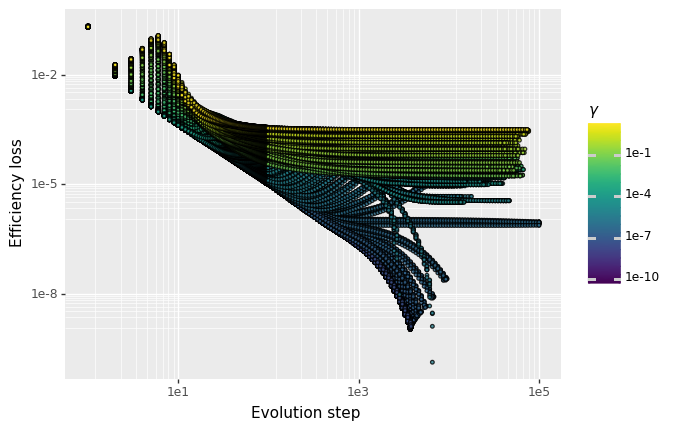

In [587]:
plot = (
    pn.ggplot(
        df_traj_analysis,
        pn.aes(
            x="iteration", 
            y="min_epsilon", 
            fill="discriminative_need_gamma",
            # color="seed",
        ),
    )
    + pn.geom_point(
        pn.aes(
            
        ),
        # size=0.5,
        size=1,
        alpha=0.8,
        )
    # + pn.geom_line()
    + pn.labs(fill="$\\gamma$")    
    + pn.xlab("Evolution step")
    + pn.ylab("Efficiency loss")

    + pn.scale_y_continuous(
        trans='log10', 
        # limits=[1e-5, 0.1],
    )
    # + pn.ylim(0,0.1)
    # + pn.xlim(0,50)
    + pn.scale_fill_continuous(trans = 'log10')
    + pn.scale_x_log10()
)
print(plot)

Helper function to get mean and confidence intervals for a variable, grouped by gamma and iteration

In [645]:
from scipy import stats

# Calculate the mean and confidence intervals for each iteration
def mean_confidence_interval(data: pd.DataFrame, confidence=0.95) -> tuple[float]:
    mean, se = np.mean(data), stats.sem(data)
    interval = se * stats.t.ppf((1 + confidence) / 2., len(data)-1)
    return (mean, mean - interval, mean + interval)

def mean_conf_df(trajectory_data: pd.DataFrame, colname: str):
    df_summary = trajectory_data.groupby(['iteration', 'discriminative_need_gamma'])[colname].apply(mean_confidence_interval).apply(pd.Series)
    df_summary.columns = [f'mean_{colname}', 'lower_ci', 'upper_ci']
    df_summary = df_summary.reset_index()
    return df_summary


/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide


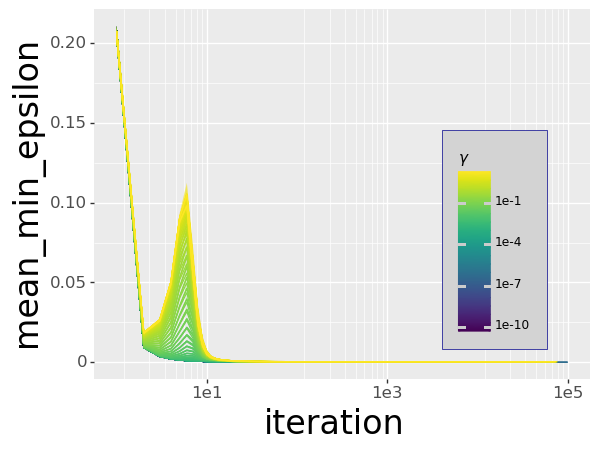


Saved a plot to figures/iterations_vs_min_epsilon.png


In [646]:
plot = (
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "min_epsilon"),
      pn.aes(
         x="iteration",
         y="mean_min_epsilon",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   # + pn.scale_y_log10()

   + pn.labs(fill="$\\gamma$", color="$\\gamma$")
   + pn.theme(
      # Axis font
      axis_title=pn.element_text(size=24),
      axis_text=pn.element_text(size=12),
      # Legend position
      legend_position=(0.75, 0.4),
      # legend_position='none',
      legend_direction = "vertical",
      # Legend box
      legend_background=pn.element_rect(
         fill="lightgrey",
         size=0.5, linetype="solid", 
         color="darkblue",
      ),
   )
   # guide not working, maybe should just use R
   + pn.guides(
      fill = pn.guide_colorbar(
         title_position = "bottom", 
         label_position = "bottom",
         override_aes = {"alpha":0.8},
         ),
   )     

)
print(plot)
save_plot(
   "figures/iterations_vs_min_epsilon.png",
   plot,
)

#### Zoom in on the spike in inefficiency

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 192 rows containing missing values.


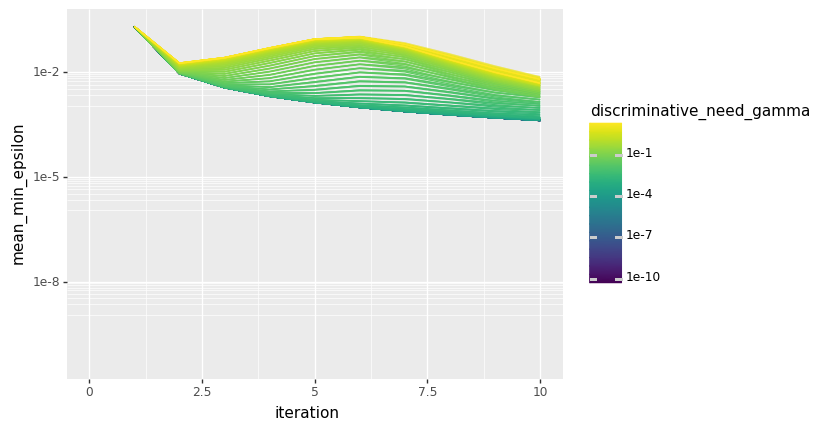

<ggplot: (887943631)>

In [590]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "min_epsilon"),
      pn.aes(
         x="iteration",
         y="mean_min_epsilon",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")  
   + pn.scale_y_log10() 
   + pn.xlim(0,10)
)

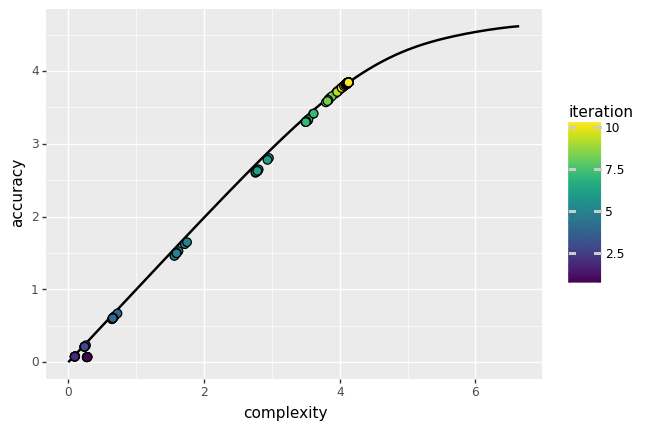

<ggplot: (816020117)>

In [591]:
# I'm so curious to see if we can see this on the trajectories. Zoom in on gamma=1000

df_traj_gamma_3 = df_traj_analysis[df_traj_analysis["discriminative_need_gamma"] == np.max(df_traj_analysis["discriminative_need_gamma"])]

(
    pn.ggplot(
        df_traj_gamma_3,
        pn.aes(
            x="complexity",
            y="accuracy",
            # color="iteration",
            # size="iteration",
            # color="discriminative_need_gamma",
        ),
    )
    # + pn.scale_size_continuous( limits=[1,5])    
    + pn.geom_line(df_ib_bound, size=1, color="black")
    + pn.geom_point(
        pn.aes(
            fill="iteration",
        ),
        size=3,        
    )
    + pn.scale_fill_continuous( 
        limits=[1,10]
    )


    # + pn.ylim(0,3)
    # + pn.xlim(0,3)
    # + pn.facet_wrap("discriminative_need_gamma")
)

#### Visualize comp vs. EU

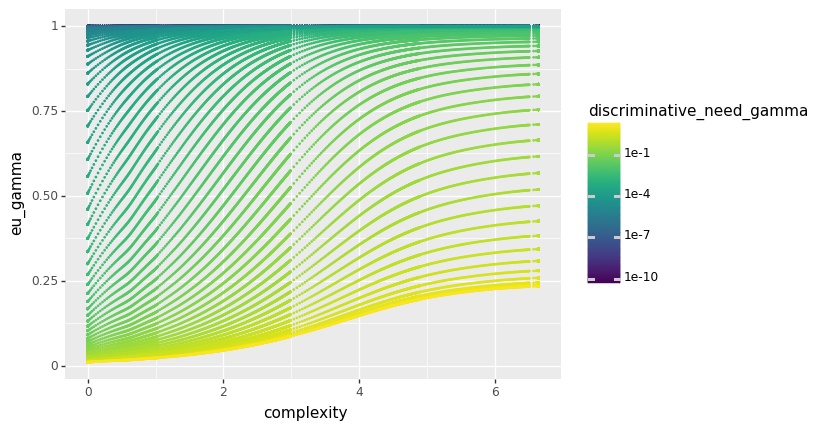

<ggplot: (842118241)>

In [592]:
# I'd like to know what the IB curves achieve in terms of their EU.

eu_cols = [colname for colname in df_ib_bound.columns if "eu_gamma=" in colname]
cols = ["complexity", "accuracy",] + eu_cols


df_ib_eu = df_ib_bound[cols].melt(
    id_vars=["complexity", "accuracy",], 
    value_vars=eu_cols, 
    var_name="discriminative_need_gamma", 
    value_name="eu_gamma",
)

# Yet another bandaid for string parsing the 0.5 width.

df_ib_eu["discriminative_need_gamma"] = df_ib_eu["discriminative_need_gamma"].apply(lambda s: s.split("eu_gamma=")[1]).astype(float)

# df_ib_eu

(
    pn.ggplot(
        df_ib_eu,
        pn.aes(
            x="complexity",
            y="eu_gamma",
            color="discriminative_need_gamma",
        ),
    )
    + pn.scale_color_continuous(trans = "log10")
    + pn.geom_point(size=0.1)
)

together?

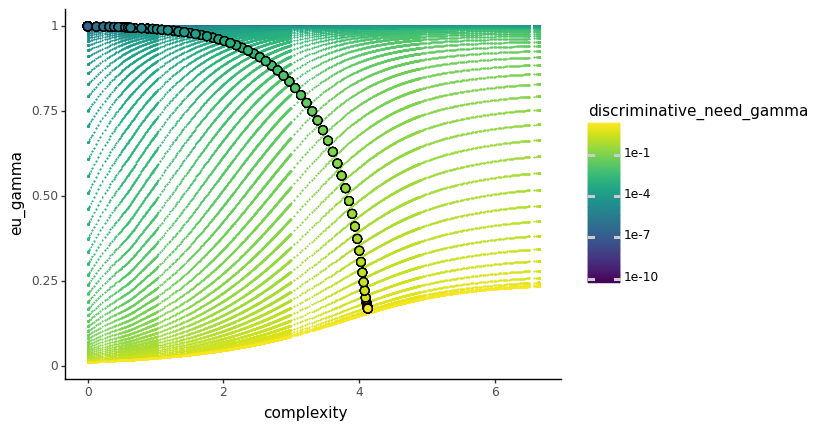

<ggplot: (864209686)>

In [653]:
(
    pn.ggplot(
        df_ib_eu,
        pn.aes(
            x="complexity",
            y="eu_gamma",
            color="discriminative_need_gamma",
        ),
    )
    + pn.geom_point(shape="+", size=0.25,)

    # Now the simulation data
    + pn.geom_point(
        df_final_points,
        pn.aes(
            fill="discriminative_need_gamma",
        ),
        shape="o",
        color="black",
        size=3,
    )
    + pn.scale_color_continuous(trans = "log10")
    + pn.scale_fill_continuous(trans = "log10")    

    # + pn.ylim(0, 0.25)
    + pn.theme_classic()
)

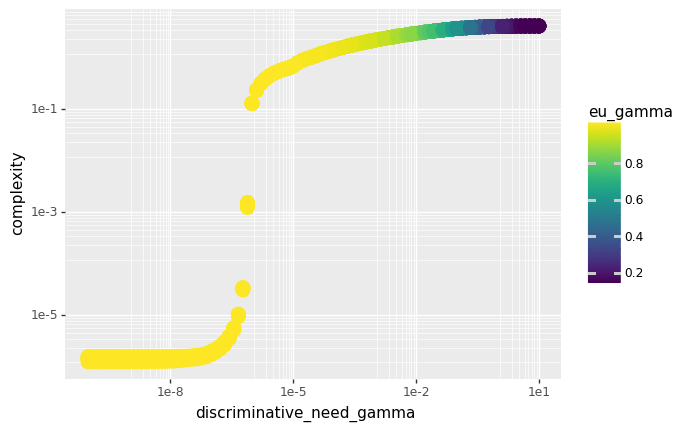

<ggplot: (816194729)>

In [677]:
(
    pn.ggplot(
        df_final_points,
        pn.aes(
            x="discriminative_need_gamma",
            y="complexity",
            color="eu_gamma",
        )
    )
    + pn.geom_point(size=5)
    + pn.scale_x_log10()
    # + pn.xlim(1e-7, 1e1)
    + pn.scale_y_log10()
)

In [666]:
# what is the first gamma that yields 0 complexity?
# probably 1e-8, based on the plot above. We'll add a 0 gamma system too.

Series([], Name: discriminative_need_gamma, dtype: float64)

In [688]:
# what is the first gamma that yields max complexity
df_final_points[df_final_points.complexity == df_final_points.complexity.max()].discriminative_need_gamma

gms = sorted(df_final_points.discriminative_need_gamma.unique())
df_final_points[df_final_points.discriminative_need_gamma == gms[-5]]

# Looks like 1e10 is a good choice for upper bound besides 1e100

,run_num,iteration,is_final_iteration,complexity,accuracy,distortion,mse,eu_gamma,kl_eb,min_epsilon,...,eu_gamma=0.21544346900318778,eu_gamma=0.5994842503189396,eu_gamma=2.1544346900318776,eu_gamma=1.6681005372000557,eu_gamma=1.2915496650148826,eu_gamma=3.5938136638046254,eu_gamma=4.641588833612772,eu_gamma=10.0,eu_gamma=5.994842503189396,eu_gamma=7.742636826811246
263404,0.0,50959.0,True,4.119598,3.837571,35.533361,5.854736,0.175518,0.0527,0.000298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263785,0.0,48897.0,True,4.119598,3.837571,36.012594,5.854736,0.175518,0.0527,0.000298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
264164,0.0,62538.0,True,4.119595,3.837569,34.200554,5.854747,0.175517,0.0527,0.000298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
264551,0.0,58564.0,True,4.119596,3.837570,32.553524,5.854743,0.175517,0.0527,0.000298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
264936,0.0,48429.0,True,4.119597,3.837571,33.721340,5.854738,0.175517,0.0527,0.000298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265315,0.0,53939.0,True,4.119598,3.837571,35.858648,5.854734,0.175518,0.0527,0.000298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265698,0.0,76905.0,True,4.119597,3.837570,34.165307,5.854741,0.175517,0.0527,0.000298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266091,0.0,37627.0,True,4.119597,3.837570,34.790370,5.854741,0.175517,0.0527,0.000298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# TODO: look at Expected Cost as MSE

# We an also look at the expected utility / cost between each emergent and its fitted beta system

complexity vs beta with utility as color (heatmap)?


In [594]:
# Sanity check that a bijective sender and bayesian receiver team will achieve at most 0.25 expected utility in the highest gamma game, because of the meaning confusion probabilities

game = Game.from_hydra(config)

encoder = np.eye(len(game.universe))
# decoder = encoder.T # not nec. ib
decoder = (encoder * game.prior[:, None]) / (encoder.T @ game.prior) @ game.meaning_dists

optimal_team = optimal_team = game.meaning_dists @ encoder @ decoder @ game.meaning_dists
high_gamma_utility = np.eye(len(game.universe))

# expected utility
np.sum(game.prior * (optimal_team * high_gamma_utility))

0.2342627097912344

In [595]:
# check that without confusion we achieve 1.0 utility
np.sum(game.prior * (np.eye(len(game.universe)) * game.utility))

0.9999999999999999

is it possible to view trajectories too? yes.

How to read the below plot: lines are ib optima, circles are trajectories of emergent systems.

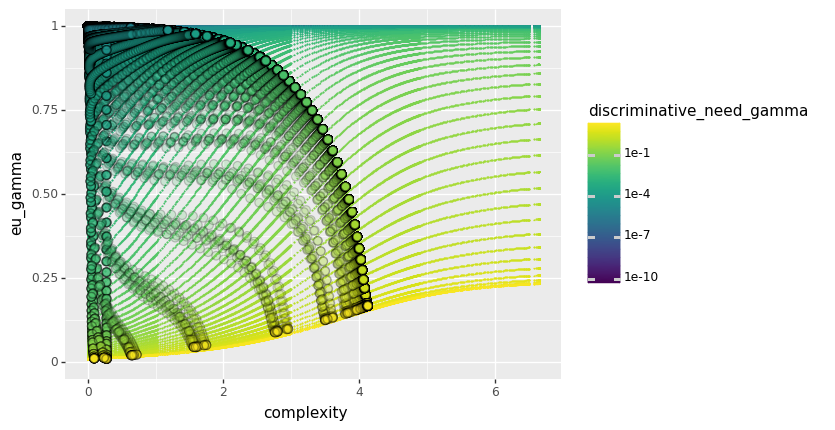

<ggplot: (820483211)>

In [596]:
df_ib_eu = df_ib_bound[cols].melt(
    id_vars=["complexity", "accuracy",], 
    value_vars=eu_cols, 
    var_name="discriminative_need_gamma", 
    value_name="eu_gamma",
)
df_ib_eu["discriminative_need_gamma"] = df_ib_eu["discriminative_need_gamma"].apply(lambda s: s.split("eu_gamma=")[1]).astype(float)

(
    pn.ggplot(
        df_ib_eu,
        pn.aes(
            x="complexity",
            y="eu_gamma",
            color="discriminative_need_gamma",
        ),
    )
    + pn.scale_color_continuous(trans = "log10")

    + pn.geom_point(
        shape="+", 
        size=0.25,
    )

    # Now the simulation data
    + pn.geom_point(
        data=df_traj_analysis, # why does the highest gamma always get overplotted? maybe we should drop anyway...
        mapping=pn.aes(
            # size="iteration",
            fill="discriminative_need_gamma",
        ),
        shape="o",
        size=3,
        alpha=0.2,
        color="black",
    )
    + pn.scale_fill_continuous(trans = "log10")
    + pn.ylim(0,1)
)

#### Visualize kl_eb over time

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide


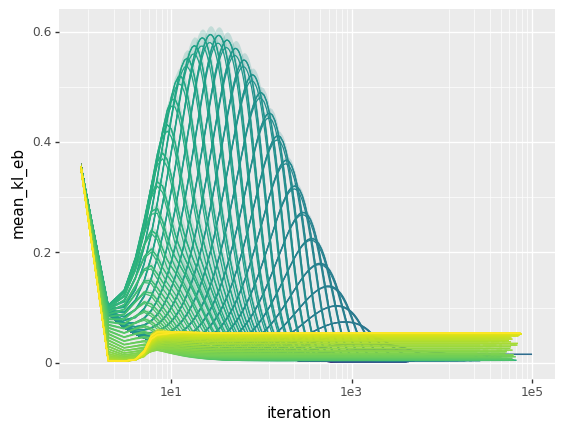


Saved a plot to figures/iterations_vs_KL_R_R_bayes.png


In [647]:
plot = (
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "kl_eb"),
      pn.aes(
         x="iteration",
         y="mean_kl_eb",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   # + pn.scale_y_log10()

   + pn.theme(
       legend_position="none",
   )


)
print(plot)
save_plot(
   "figures/iterations_vs_KL_R_R_bayes.png",
   plot,
)

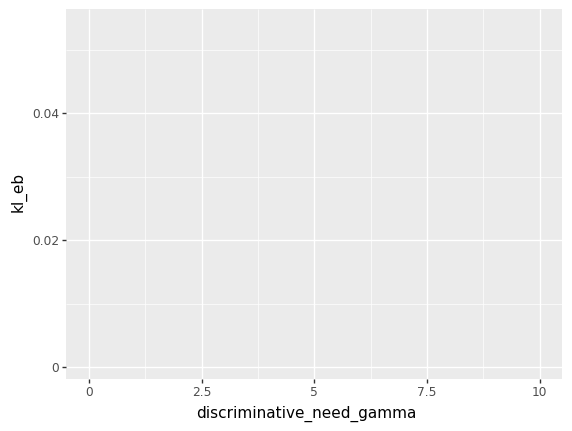

In [661]:
# TODO: plot gamma agsint kl just for converged systems

plot = (
   pn.ggplot(
      df_final_points,
      pn.aes(
         x="discriminative_need_gamma",
         y="kl_eb",
      )
   )
   # + pn.scale_x_log10()
   # + pn.scale_y_log10()

   + pn.theme(
       legend_position="none",
   )


)
print(plot)


/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide


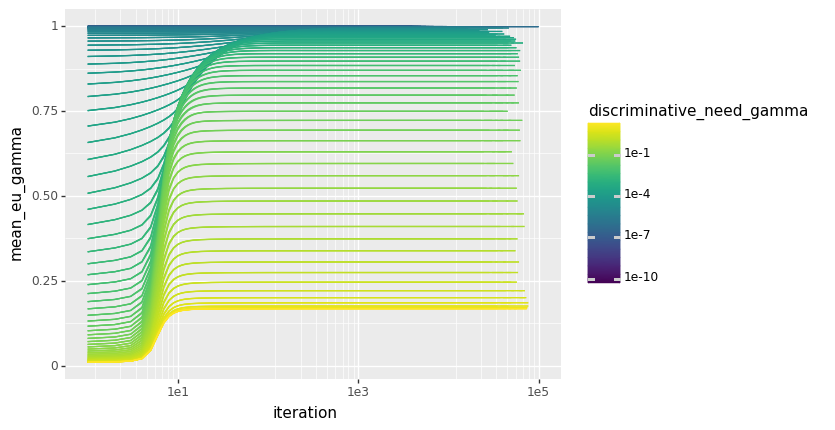

<ggplot: (816420372)>

In [598]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "eu_gamma"),
      pn.aes(
         x="iteration",
         y="mean_eu_gamma",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   # + pn.scale_y_log10()
)

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide


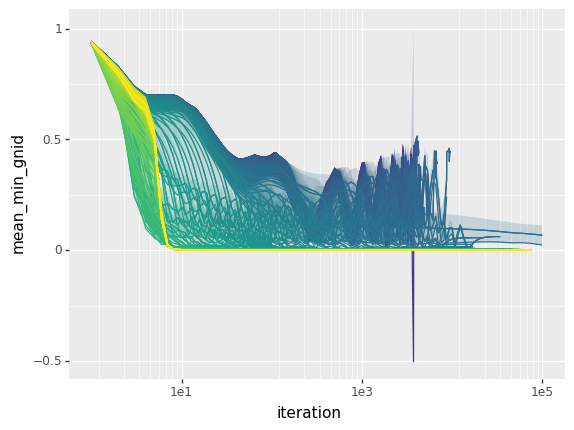


Saved a plot to figures/iterations_vs_min_gNID.png


In [648]:
mean_min_gnid_df = mean_conf_df(df_traj_analysis, "min_gnid")

plot = (
   pn.ggplot(
      mean_min_gnid_df,
      pn.aes(
         x="iteration",
         y="mean_min_gnid",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   # + pn.scale_y_log10()
   + pn.theme(
       legend_position="none",
   )

)
print(plot)
save_plot(
   "figures/iterations_vs_min_gNID.png",
   plot,
)

In [652]:
# Note that gNID is not necessarily nonnegative
# df_traj_analysis[df_traj_analysis["min_gnid"] < 0]


df_traj_analysis[df_traj_analysis["discriminative_need_gamma"] == mean_min_gnid_df[mean_min_gnid_df["lower_ci"] < 0].discriminative_need_gamma.item()].min_gnid

36781    0.944756
36782    0.842565
36783    0.767165
36784    0.710899
36785    0.695784
           ...   
39075    0.395451
39076    0.093649
39077    0.287071
39078    0.484571
39079    0.193229
Name: min_gnid, Length: 1222, dtype: float64

iteration                         4.0
min_epsilon                  0.002119
min_epsilon_beta             1.000657
discriminative_need_gamma         0.0
population_init_tau               NaN
complexity                   0.026956
accuracy                     0.024822
seed                              2.0
kl_eb                        0.053425
eu_gamma                     0.999979
min_gnid                     0.640733
gnid_beta                    1.000657
Name: 30347, dtype: object

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide


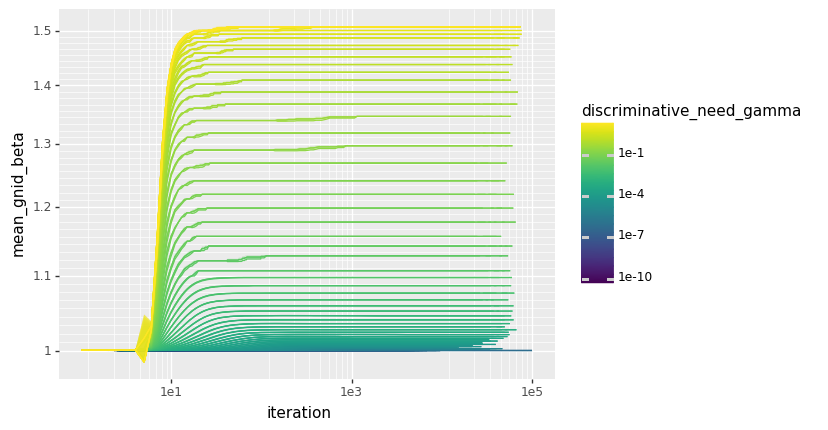

<ggplot: (887327555)>

In [601]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "gnid_beta"),
      pn.aes(
         x="iteration",
         y="mean_gnid_beta",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   + pn.scale_y_log10()
)

N.B., this is different from beta fitted by min epsilon!

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide


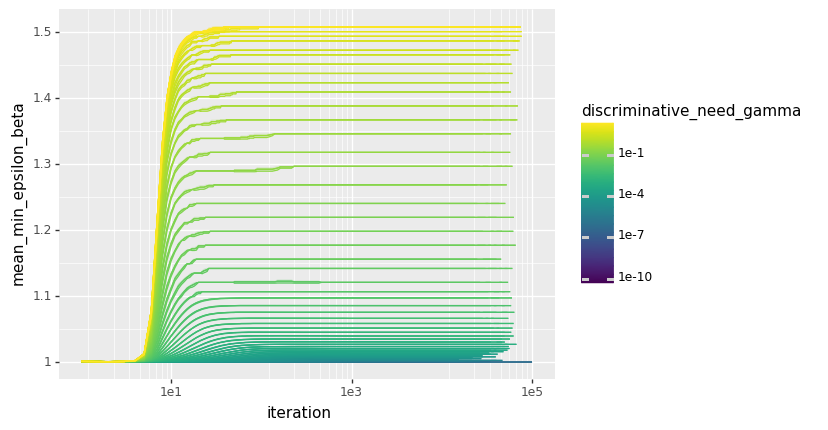

<ggplot: (816044756)>

In [602]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "min_epsilon_beta"),
      pn.aes(
         x="iteration",
         y="mean_min_epsilon_beta",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   # + pn.scale_y_log10()
)

Whats the difference between epsilon-fitted and gnid-fitted betas?

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide


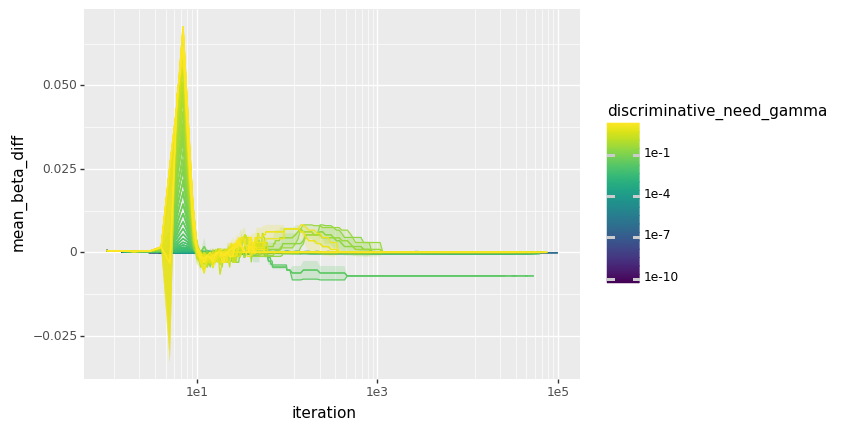

<ggplot: (887707736)>

In [603]:
df1 = mean_conf_df(df_traj_analysis, "min_epsilon_beta")
df2 = mean_conf_df(df_traj_analysis, "gnid_beta")
df3 = df1[["iteration", "discriminative_need_gamma"]].copy()
df3["mean_beta_diff"] = df1.mean_min_epsilon_beta - df2.mean_gnid_beta
df3["lower_ci_diff"] = df1.lower_ci - df2.lower_ci
df3["upper_ci_diff"] = df1.upper_ci - df2.upper_ci

(
   pn.ggplot(
      df3,
      pn.aes(
         x="iteration",
         y="mean_beta_diff",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci_diff",
         ymax = "upper_ci_diff",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
)